In [19]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
import datetime as dt
import matplotlib.pyplot as plt

import requests

# Stock source from yahoo finance

In [2]:
ticker = 'aapl'
# Last 3 years closing prices starting from Jan 2, 2018.
 
now = dt.datetime.now()
startyear = 2018
startmonth = 1 
startday = 2
start = dt.datetime(startyear, startmonth, startday)
df = pdr.get_data_yahoo(ticker, start, now)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-11-15,151.880005,149.429993,150.369995,150.000000,59222800.0,150.000000
2021-11-16,151.490005,149.339996,149.940002,151.000000,59256200.0,151.000000
2021-11-17,155.000000,150.990005,151.000000,153.490005,88807000.0,153.490005
2021-11-18,158.669998,153.050003,153.710007,157.869995,137827700.0,157.869995
2021-11-19,161.020004,156.532806,157.649994,160.550003,111823351.0,160.550003


# Cypto source from HOUBI

In [56]:

base = 'https://api.huobi.pro'
url = '/market/history/kline?period=5min&size=2000&symbol=ethbtc'
final_url = base + url
reqs = requests.get(final_url)

df = pd.DataFrame(reqs.json()['data'])
df.rename(columns={'high':'High','low':'Low','open':'Open','close':'Close','vol':'Volume'},inplace=True)
df['Adj Close']= df['Close']
df = df[['High','Low','Open','Close','Volume','Adj Close']]

df

,High,Low,Open,Close,Volume,Adj Close
0,0.073812,0.073783,0.073793,0.073783,0.359191,0.073783
1,0.073829,0.073794,0.073794,0.073794,1.303208,0.073794
2,0.073821,0.073750,0.073751,0.073804,0.568392,0.073804
3,0.073760,0.073710,0.073727,0.073734,0.799447,0.073734
4,0.073773,0.073709,0.073730,0.073744,1.971679,0.073744
...,...,...,...,...,...,...
1995,0.072752,0.072638,0.072658,0.072704,2.016257,0.072704
1996,0.072694,0.072636,0.072673,0.072652,0.114765,0.072652
1997,0.072687,0.072640,0.072642,0.072664,0.145493,0.072664
1998,0.072660,0.072608,0.072616,0.072638,0.263843,0.072638


In [57]:
## 14_Day RSI
df['Up Move'] = np.nan
df['Down Move'] = np.nan
df['Average Up'] = np.nan
df['Average Down'] = np.nan
# Relative Strength
df['RS'] = np.nan
# Relative Strength Index
df['RSI'] = np.nan

    

# Relative Strength Index (RSI):
## When the RSI surpasses the horizontal 30 reference level, it is a bullish sign and when it slides below the horizontal 70 reference level, it is a bearish sign.

In [58]:
## Calculate Up Move & Down Move
for x in range(1, len(df)):
    df['Up Move'][x] = 0
    df['Down Move'][x] = 0
    
    if df['Adj Close'][x] > df['Adj Close'][x-1]:
        df['Up Move'][x] = df['Adj Close'][x] - df['Adj Close'][x-1]
        
    if df['Adj Close'][x] < df['Adj Close'][x-1]:
        df['Down Move'][x] = abs(df['Adj Close'][x] - df['Adj Close'][x-1])  
        


In [59]:
## Calculate initial Average Up & Down, RS and RSI
df['Average Up'][14] = df['Up Move'][1:15].mean()
df['Average Down'][14] = df['Down Move'][1:15].mean()
df['RS'][14] = df['Average Up'][14] / df['Average Down'][14]
df['RSI'][14] = 100 - (100/(1+df['RS'][14]))


In [60]:
## Calculate rest of Average Up, Average Down, RS, RSI
for x in range(15, len(df)):
    df['Average Up'][x] = (df['Average Up'][x-1]*13+df['Up Move'][x])/14
    df['Average Down'][x] = (df['Average Down'][x-1]*13+df['Down Move'][x])/14
    df['RS'][x] = df['Average Up'][x] / df['Average Down'][x]
    df['RSI'][x] = 100 - (100/(1+df['RS'][x]))

## - You can ‘print(df)’ to see the DataFrame, it should look like a long table with 6 new columns.
# Plot the RSI and ‘Close Prices’ :

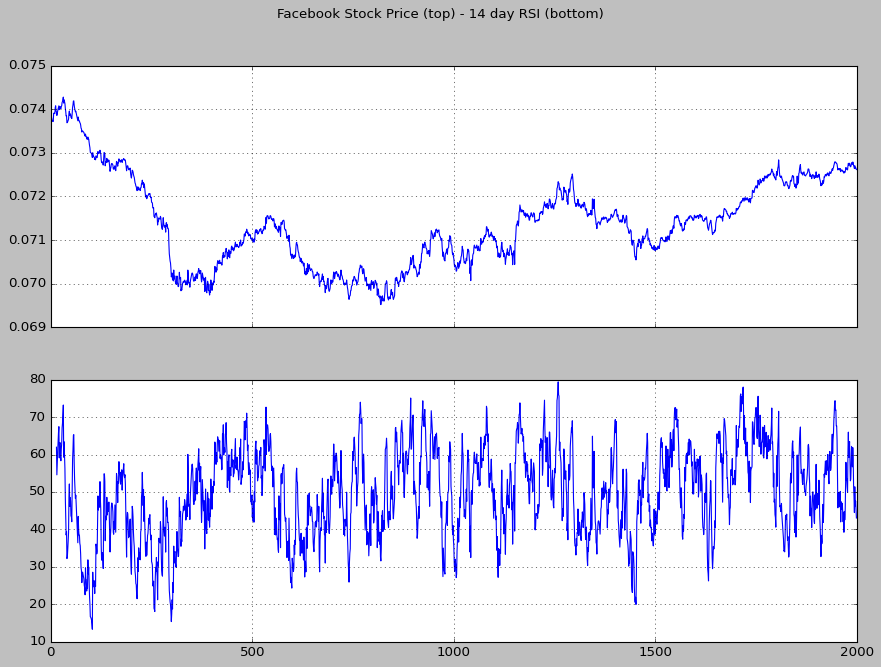

In [61]:
## Chart the stock price and RSI
#plt.style.use('_classic_test')
fig, axs = plt.subplots(2, sharex=True, figsize=(13,9))
fig.suptitle('Facebook Stock Price (top) - 14 day RSI (bottom)')
axs[0].plot(df['Adj Close'])
axs[1].plot(df['RSI'])
axs[0].grid()
axs[1].grid()

# GENERATE BUY & SELL SIGNALS:

In [62]:
## Calculate the buy & sell signals
## Initialize the columns that we need
df['Long Tomorrow'] = np.nan
df['Buy Signal'] = np.nan
df['Sell Signal'] = np.nan
df['Buy RSI'] = np.nan
df['Sell RSI'] = np.nan
df['Strategy'] = np.nan
## Calculate the buy & sell signals
for x in range(15, len(df)):
    
    # Calculate "Long Tomorrow" column
    if ((df['RSI'][x] <= 40) & (df['RSI'][x-1]>40) ):
        df['Long Tomorrow'][x] = True
    elif ((df['Long Tomorrow'][x-1] == True) & (df['RSI'][x] <= 70)):
        df['Long Tomorrow'][x] = True
    else:
        df['Long Tomorrow'][x] = False
        
    # Calculate "Buy Signal" column
    if ((df['Long Tomorrow'][x] == True) & (df['Long Tomorrow'][x-1] == False)):
        df['Buy Signal'][x] = df['Adj Close'][x]
        df['Buy RSI'][x] = df['RSI'][x]
        
    # Calculate "Sell Signal" column
    if ((df['Long Tomorrow'][x] == False) & (df['Long Tomorrow'][x-1] == True)):
        df['Sell Signal'][x] = df['Adj Close'][x]
        df['Sell RSI'][x] = df['RSI'][x]
        
## Calculate strategy performance
df['Strategy'][15] = df['Adj Close'][15]
for x in range(16, len(df)):
    if df['Long Tomorrow'][x-1] == True:
        df['Strategy'][x] = df['Strategy'][x-1]* (df['Adj Close'][x] / df['Adj Close'][x-1])
    else:
        df['Strategy'][x] = df['Strategy'][x-1]

<ipython-input-62-5bd053afbd08>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Long Tomorrow'][x] = False
<ipython-input-62-5bd053afbd08>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Long Tomorrow'][x] = True
<ipython-input-62-5bd053afbd08>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Buy Signal'][x] = df['Adj Close'][x]
<ipython-input-62-5bd053afbd08>:23: SettingWithCopyWarning: 
A value is trying to be set on

# Exit / Entry:

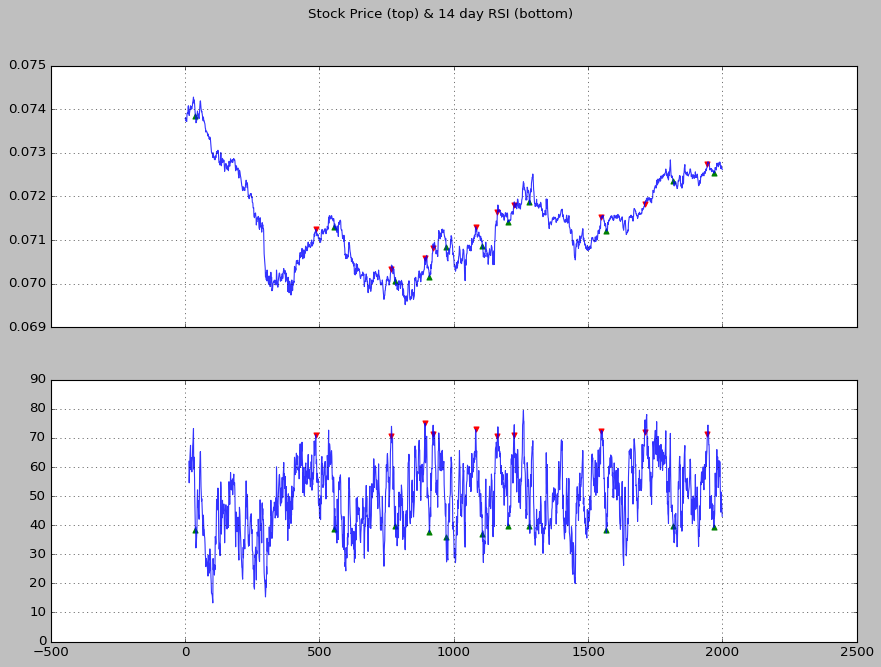

In [63]:
## Chart the buy/sell signals:
#plt.style.use('_classic_test')
fig, axs = plt.subplots(2, sharex=True, figsize=(13,9))
fig.suptitle('Stock Price (top) & 14 day RSI (bottom)')
## Chart the stock close price & buy/sell signals:
axs[0].scatter(df.index, df['Buy Signal'],  color = 'green',  marker = '^', alpha = 1)
axs[0].scatter(df.index, df['Sell Signal'],  color = 'red',  marker = 'v', alpha = 1)
axs[0].plot(df['Adj Close'], alpha = 0.8)
axs[0].grid()
## Chart RSI & buy/sell signals:
axs[1].scatter(df.index, df['Buy RSI'],  color = 'green', marker = '^', alpha = 1)
axs[1].scatter(df.index, df['Sell RSI'],  color = 'red', marker = 'v', alpha = 1)
axs[1].plot(df['RSI'], alpha = 0.8)
axs[1].grid()

# Moving Average Convergence Divergence (MACD):

In [64]:
## Calculate the MACD and Signal Line indicators
## Calculate the Short Term Exponential Moving Average
ShortEMA = df.Close.ewm(span=12, adjust=False).mean() 
## Calculate the Long Term Exponential Moving Average
LongEMA = df.Close.ewm(span=26, adjust=False).mean() 
## Calculate the Moving Average Convergence/Divergence (MACD)
MACD = ShortEMA - LongEMA
## Calcualte the signal line
signal = MACD.ewm(span=9, adjust=False).mean()

## Plot MACD & Signal Line:

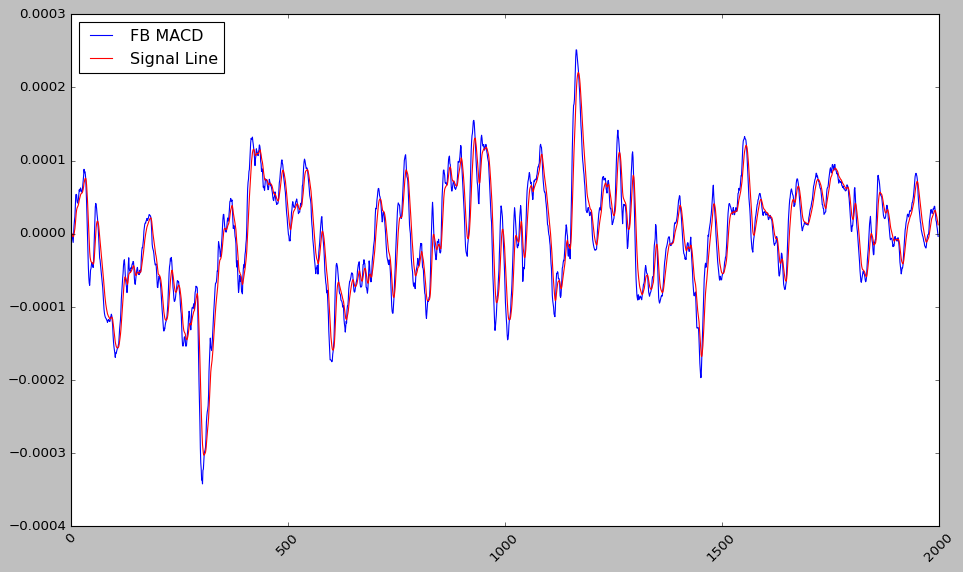

In [65]:
## Plot the Chart
plt.figure(figsize=(14,8))
plt.style.use('classic')
plt.plot(df.index, MACD, label='FB MACD', color = 'blue')
plt.plot(df.index, signal, label='Signal Line', color='red')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

# Trading Facebook 3-Year Metrics:

In [66]:
## Performance statistics
## Number of trades
trade_count = df['Buy Signal'].count()
## Average Profit per/trade:
average_profit = ((df['Strategy'].iloc[-1] / df['Strategy'].iloc[15])**(1/trade_count))-1
## Number of days per/trade
total_days = df['Long Tomorrow'].count()
average_days = int(total_days / trade_count)
print('Strategy yielded ', trade_count, ' trades')
print('Average trade lasted ', average_days, ' days per trade')
print('Our average profit per trade was ', average_profit*100, '%')

Strategy yielded  11  trades
Average trade lasted  180  days per trade
Our average profit per trade was  0.0054761348998288994 %


In [44]:
df.head(20)


,High,Low,Open,Close,Volume,Adj Close,Up Move,Down Move,Average Up,Average Down,RS,RSI,Long Tomorrow,Buy Signal,Sell Signal,Buy RSI,Sell RSI,Strategy
0,58560.09,57947.80,58053.41,58225.57,2.203160e+07,58225.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,58135.53,57733.06,57826.34,58053.42,1.277155e+07,58053.42,0.00,172.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,58004.54,57693.16,57802.59,57826.34,8.268344e+06,57826.34,0.00,227.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,57929.59,57541.36,57772.32,57802.59,1.392800e+07,57802.59,0.00,23.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,58122.84,57692.30,58037.75,57772.40,1.028464e+07,57772.40,0.00,30.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,58080.43,57677.88,57883.19,58037.76,7.772275e+06,58037.76,265.36,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,58080.24,57754.22,57979.00,57879.36,1.081661e+07,57879.36,0.00,158.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,58319.65,57943.70,58153.97,57979.00,2.027391e+07,57979.00,99.64,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,58231.83,57753.14,57881.39,58153.97,1.913060e+07,58153.97,174.97,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,58152.00,57632.80,57992.05,57881.38,2.146291e+07,57881.38,0.00,272.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df['Strategy'][15]

41.656803131103516

In [17]:
df['Strategy'].iloc[15]

41.656803131103516